In [165]:
# here, we will solve the burgers equation using an NN to reduce the error
# we will use an FDM solver for the burgers equation

# du/dt + u*du/dx = nu*d^2u/dx^2

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [167]:
# here we use an FDM solver to solve the burgers equation

# first, we create the grid

N = 128
DX = 2/N
STEPS = 32 # this is how many steps we will take
DT = 1/STEPS
NU = 0.01/(N*np.pi)

initial_velocity = np.zeros(N) # this is in 1D (velocity for each point only)


# here is the final solution (reference)

reference = torch.tensor([0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312])

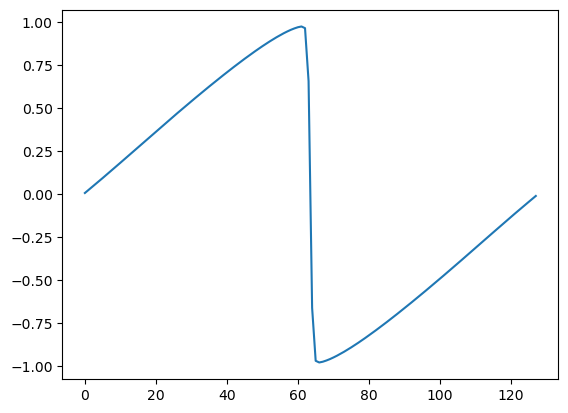

In [168]:
# here is the reference solution at time t=0.5 (step 16)
plt.plot(reference)
plt.show()

In [169]:
def velocity_step(last_velocity, nu, dt, dx):
    # here we use the finite difference method to calculate the next velocity

    new_velocity = torch.zeros(N)

    for i in range(N):
        ui = last_velocity[i]
        ui1 = last_velocity[(i+1)] if i < N-1 else last_velocity[0]
        uineg1 = last_velocity[(i-1)] if i > 0 else last_velocity[N-1]
        new_velocity[i] = ui - dt * (ui * (ui1 - uineg1) / (2 * dx)) + nu * dt * (ui1 - 2*ui + uineg1) / (dx**2)


        # if i == 127:
        #     break
        # un = last_velocity

        # new_velocity[i] = un[i] - un[i]*dt/dx*(un[i] - un[i-1]) + nu*dt/dx**2*(un[i+1]-2*un[i]+un[i-1])

        # #periodic boudnary condition
        
        # new_velocity[0] = un[0] - un[0]*dt/dx*(un[0] - un[-2]) + nu*dt/dx**2*(un[1]-2*un[0]+un[-2])
        # new_velocity[-1] = last_velocity[0]



    # # Update the velocities using the given formula
    # new_velocity[1:-1] = (last_velocity[1:-1] + 
    #                       dt * (nu * (last_velocity[2:] - 2 * last_velocity[1:-1] + last_velocity[:-2]) / dx**2
    #                       + 0.25 * (last_velocity[2:]**2 - last_velocity[:-2]**2) / dx))

    # # Handle the boundary conditions
    # new_velocity[0] = last_velocity[0]
    # new_velocity[-1] = last_velocity[-1]


    return new_velocity



def loss_function(velocity, reference):
    velocities = [velocity] # velocity is the initial velocity (at time t=0)

    # here we step through each step to get updated velocities
    for n in range(STEPS):
        # use a function here that uses the finite difference method to calculate the next step

        next_v = velocity_step(velocities[-1], NU, DT, DX)
        
        # nx = N
        # u = velocities[-1]
        # nu = NU
        # dt = DT
        # dx = DX
        # new_velocity = torch.zeros(N)
        # new_velocity[0] = u[0]
        # new_velocity[nx-1] = u[nx-1]
        # new_velocity[1:nx-1] = (u[1:nx-1] + 
        #               dt * (nu * (u[2:nx] - 2 * u[1:nx-1] + u[0:nx-2]) / dx**2
        #               + 0.25 * (u[2:nx]**2 - u[0:nx-2]**2) / dx))
        # next_v = new_velocity

        # print(next_v)

        velocities.append(next_v)

    # calculate the l2 loss here
    # loss = np.linalg.norm(velocities[16] - reference, ord=2)

    loss = torch.norm(velocities[12] - reference, p=2)

    # loss = torch.mean((velocities[16] - reference) ** 2)

    return loss, velocities

In [178]:
velocity = torch.tensor(np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ), requires_grad=True)
loss, velocities = loss_function(velocity, reference)
loss.backward()

In [180]:
print(loss)

tensor(1.3737, grad_fn=<LinalgVectorNormBackward0>)


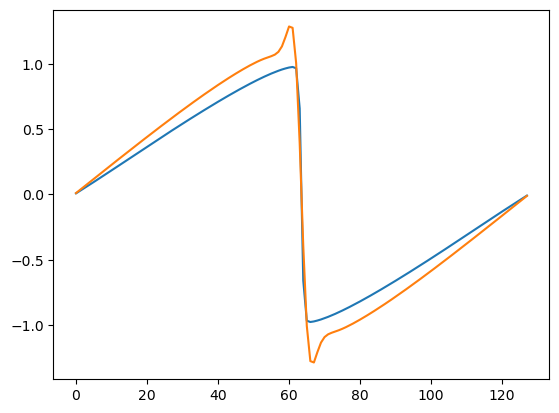

In [186]:
plt.plot(reference)
plt.plot(velocities[12].detach().numpy())
plt.show()

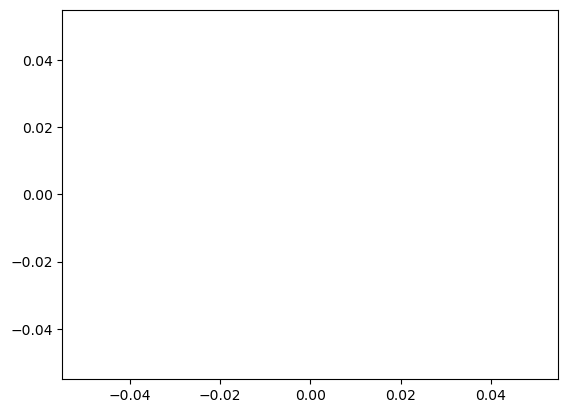

In [12]:
# plotting the gradient vs the velocity

plt.plot(velocity.grad)
plt.plot(velocity.detach().numpy())
plt.show()

In [13]:
velocity.grad.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

In [175]:
# OPTIMIZATION TIME!

LR = 0.01

grads = []

velocity = torch.tensor(initial_velocity, requires_grad=True)

# let's use the adam optimizer instead
optimizer = torch.optim.Adam([velocity], lr=LR)

for optim_step in range(100):


    # print(velocity[0])

    loss, velocities = loss_function(velocity, reference)

    print(loss)

    # if loss < 4.4:
    #     break


    # loss.backward
    loss.backward()

    grads.append(velocity.grad)

    optimizer.step()
    # with torch.no_grad():
    #     velocity -= LR * velocity.grad

    optimizer.zero_grad()
    # velocity.grad.zero_()

tensor(7.0009, grad_fn=<LinalgVectorNormBackward0>)
tensor(6.9016, grad_fn=<LinalgVectorNormBackward0>)
tensor(6.8016, grad_fn=<LinalgVectorNormBackward0>)
tensor(6.7001, grad_fn=<LinalgVectorNormBackward0>)
tensor(6.5962, grad_fn=<LinalgVectorNormBackward0>)
tensor(6.4876, grad_fn=<LinalgVectorNormBackward0>)
tensor(6.3736, grad_fn=<LinalgVectorNormBackward0>)
tensor(6.2983, grad_fn=<LinalgVectorNormBackward0>)
tensor(6.1851, grad_fn=<LinalgVectorNormBackward0>)
tensor(6.0858, grad_fn=<LinalgVectorNormBackward0>)
tensor(5.9951, grad_fn=<LinalgVectorNormBackward0>)
tensor(5.9043, grad_fn=<LinalgVectorNormBackward0>)
tensor(5.8115, grad_fn=<LinalgVectorNormBackward0>)
tensor(5.7169, grad_fn=<LinalgVectorNormBackward0>)
tensor(5.6209, grad_fn=<LinalgVectorNormBackward0>)
tensor(5.5241, grad_fn=<LinalgVectorNormBackward0>)
tensor(5.4277, grad_fn=<LinalgVectorNormBackward0>)
tensor(5.3340, grad_fn=<LinalgVectorNormBackward0>)
tensor(5.2443, grad_fn=<LinalgVectorNormBackward0>)
tensor(5.153

KeyboardInterrupt: 

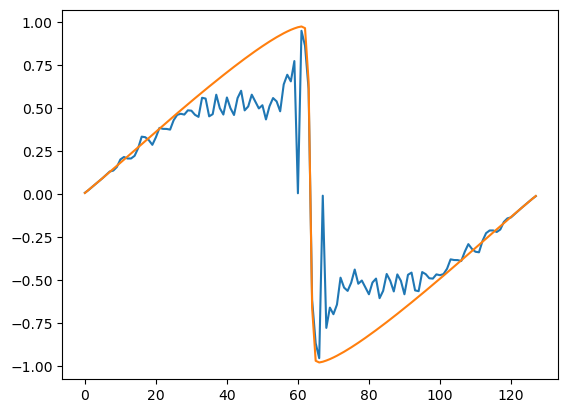

In [176]:
plt.plot(velocities[12].detach().numpy())
plt.plot(reference)
plt.show()

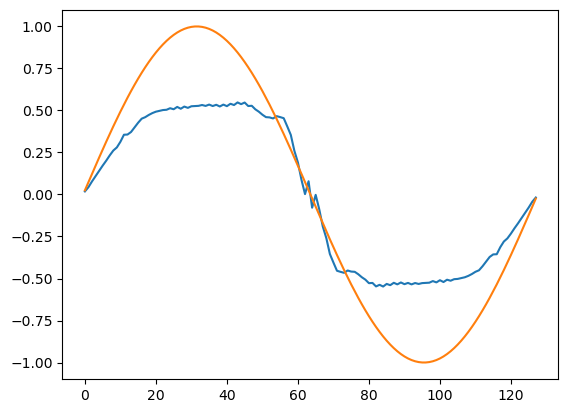

In [177]:
plt.plot(velocities[0].detach().numpy())
# plt.plot(reference)
plt.plot(np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ))
plt.show()

In [ ]:
loss

7.000939392541187

In [ ]:
# here we define a NN to correct the errors from the FDM

In [ ]:
# here we train the NN to correct the errors from the FDM